In [2]:
# import cv2
import glob
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL.Image as Image 
import random
import tensorflow as tf

## Read the data

In [21]:
# get the image data
# TODO: I cannot read all data at once, I will need to find a way to deal with that
num_frames = 10
num_videos = 2

ext = ".jpg"
train_data_dir = "data/train/"
test_data_dir  = "data/test/"

train_dir_paths = sorted(glob.glob(os.path.join(train_data_dir, "MOT16*")))
train_img_paths = [sorted(glob.glob(os.path.join(p,"*/*"+ext))) for p in train_dir_paths]
test_dir_paths = sorted(glob.glob(os.path.join(test_data_dir, "MOT16*")))
test_img_paths = [sorted(glob.glob(os.path.join(p,"*/*"+ext))) for p in test_dir_paths]

X_train = [np.array([np.array(Image.open(fname)) for fname in p[:num_frames]]) for p in train_img_paths[:num_videos]]
X_test = [np.array([np.array(Image.open(fname)) for fname in p[:num_frames]]) for p in test_img_paths[:num_videos]]

In [22]:
# here. I can set x,y,z to -1. Conf can be set to -1
# as well.
# x,y,z are for 3d tracking which is not the case
# conf is confidence in pred from detection alg.
det_header    = ["frame", "id", "bb_left", "bb_top", "bb_width",\
                 "bb_height", "conf", "x", "y", "z"]
gt_header     = ["frame", "id", "bb_left", "bb_top", "bb_width",\
                 "bb_height", "x", "y", "z"]
output_header = ["frame", "id", "bb_left", "bb_top", "bb_width",\
                 "bb_height", "conf", "x", "y", "z"]               
                                                                   

In [23]:
# get the detection data
train_det_paths = glob.glob(os.path.join(train_data_dir, "*/det/det.txt"))
train_det_paths.sort()
train_det = [pd.DataFrame(np.loadtxt(i, delimiter=","), columns=det_header) for i in train_det_paths[:num_videos]]
train_det[0] # visualize

,frame,id,bb_left,bb_top,bb_width,bb_height,conf,x,y,z
0,1.0,-1.0,1359.10,413.27,120.260,362.770,2.309200,-1.0,-1.0,-1.0
1,1.0,-1.0,571.03,402.13,104.560,315.680,1.502800,-1.0,-1.0,-1.0
2,1.0,-1.0,650.80,455.86,63.980,193.940,0.332760,-1.0,-1.0,-1.0
3,1.0,-1.0,721.23,446.86,41.871,127.610,0.274010,-1.0,-1.0,-1.0
4,1.0,-1.0,454.06,434.36,97.492,294.470,0.208180,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...
7262,600.0,-1.0,1005.60,375.27,97.492,294.470,-0.097509,-1.0,-1.0,-1.0
7263,600.0,-1.0,708.37,476.87,20.435,63.306,-0.148300,-1.0,-1.0,-1.0
7264,600.0,-1.0,421.14,446.86,41.871,127.610,-0.199710,-1.0,-1.0,-1.0
7265,600.0,-1.0,613.25,412.69,51.780,157.340,-0.386270,-1.0,-1.0,-1.0


In [24]:
# get the ground truth data
train_gt_paths = glob.glob(os.path.join(train_data_dir, "*/gt/gt.txt"))
train_gt_paths.sort()
train_gt = [pd.DataFrame(np.loadtxt(i, delimiter=","), columns=gt_header) for i in train_gt_paths[:num_videos]]
train_gt[0]

,frame,id,bb_left,bb_top,bb_width,bb_height,x,y,z
0,1.0,1.0,912.0,484.0,97.0,109.0,0.0,7.0,1.0
1,2.0,1.0,912.0,484.0,97.0,109.0,0.0,7.0,1.0
2,3.0,1.0,912.0,484.0,97.0,109.0,0.0,7.0,1.0
3,4.0,1.0,912.0,484.0,97.0,109.0,0.0,7.0,1.0
4,5.0,1.0,912.0,484.0,97.0,109.0,0.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...
29188,581.0,73.0,1044.0,445.0,31.0,94.0,1.0,1.0,0.0
29189,591.0,74.0,1044.0,445.0,31.0,97.0,1.0,1.0,0.0
29190,592.0,74.0,1043.0,445.0,32.0,97.0,1.0,1.0,0.0
29191,593.0,74.0,1043.0,445.0,32.0,97.0,1.0,1.0,0.0


## Visualize the data

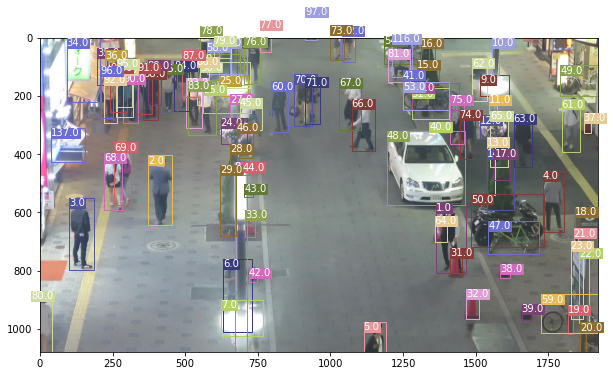

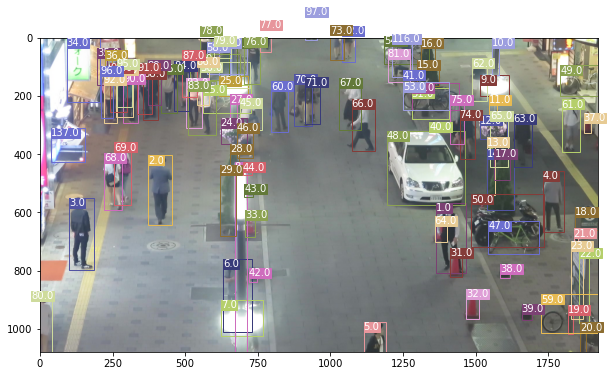

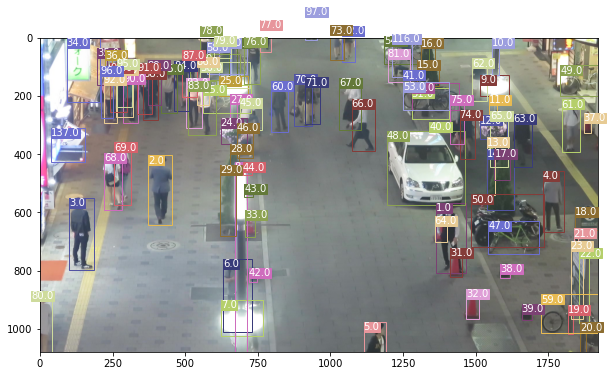

In [25]:
video = 1
frame_range = (5,8)
det = train_det[video][train_det[video].loc[:,"frame"] == frame_range[0]+1] 
gt = train_gt[video][train_gt[video].loc[:,"frame"] == frame_range[0]+1]

IDs = np.unique(gt.loc[:,"id"]).tolist()

cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, len(IDs))]

id_color_map = {id:random.sample(colors,1)[0] for id in IDs}

for frame in range(*frame_range):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(X_train[video][frame])
    # for i in range(len(det)):
    #     x,y,w,h = det[i,2:6]
    #     bb = patches.Rectangle((x,y),w,h, linewidth=1, edgecolor='g', facecolor='none')
    #     ax.add_patch(bb)
    for i in range(len(gt)):
        ID,x,y,w,h = gt.iloc[i,1:6]
        color = id_color_map[ID]
        bb = patches.Rectangle((x,y),w,h, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(bb)
        plt.text(x, y, s="{}".format(ID), 
            color='white', verticalalignment='top',
            bbox={'color': color, 'pad': 0})
    plt.show()

## Form the anchor, positive and negative datasets

In [26]:
vid_id_images = []
for vid in range(len(train_det)):
    gt = train_gt[vid]
    frames = sorted(gt.loc[:,"frame"].unique().tolist())
    id_images = {}
    gt_frames = gt.loc[(gt.frame>= frame_range[0]) & (gt.frame<frame_range[1]),:]
    for row in gt_frames.iterrows():
        frame, id_, x, y, w, h = row[1][:6]
        frame = (int)(frame)
        id_ = (int)(id_)
        x1 = (int)(x)
        y1 = (int)(y)
        x2 = (int)(x+w)
        y2 = (int)(y+h)
        # TODO: deal with the gt that are specified with negative numbers instead of discarding them
        if (x1 < 0) or (x2 < 0) or (y1 < 0) or (y2 < 0):
            continue
        if id_ in id_images:
            id_images[id_].append(X_train[vid][frame,y1:y2,x1:x2,:])
        else:
            id_images[id_] = [X_train[vid][frame,y1:y2,x1:x2,:]]
    vid_id_images.append(id_images)

In [27]:
target_shape = (200, 200)
num_samples = 4


# for each video, put all 
# TODO: I could maybe make an iterator out of that
anchor_images = tf.convert_to_tensor([])
positive_images = tf.convert_to_tensor([])
negative_images = tf.convert_to_tensor([])



# TODO: properly reference source (same as below): https://keras.io/examples/vision/siamese_network/
def preprocess_image(image):
    """
    Take in an RGB image represented by a numpy array, preprocess it and
    resize it to the target shape.
    """
#     image_string = tf.io.read_file(filename)
#     image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.convert_to_tensor(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image

for id_images in vid_id_images:
    # TODO: improve by not doing random iterations but actually doing epochs over all the data
    for id_ in id_images.keys():
        # anchor samples
        anchor_sample_idxs = np.random.choice(len(id_images[id_]), num_samples)
        anc_to_add = tf.stack([preprocess_image(id_images[id_][i]) for i in anchor_sample_idxs])
        # positive samples
        # TODO: make sure that the anchor and positive aren't the same
        positive_sample_idxs = np.random.choice(len(id_images[id_]), num_samples)
        pos_to_add = tf.stack([preprocess_image(id_images[id_][i]) for i in positive_sample_idxs])
        # negative sampled indices
        neg_idxs = [neg_id for neg_id in id_images.keys() if neg_id != id_]
        neg_sample_idxs = [(neg_id, random.randint(0,len(id_images[neg_id])-1)) for neg_id in np.random.choice(neg_idxs,num_samples)]
        neg_to_add = tf.stack([preprocess_image(id_images[i][j]) for i,j in neg_sample_idxs])
        # sample negative examples
        if len(positive_images) != 0:
            positive_images = tf.concat([positive_images, pos_to_add],0)
            anchor_images = tf.concat([anchor_images, anc_to_add],0)
            negative_images = tf.concat([negative_images, neg_to_add],0)
        else:
            positive_images = pos_to_add
            anchor_images = anc_to_add
            negative_images = neg_to_add
            
            
print("positive shape: {}".format(positive_images.shape))
print("anchor shape: {}".format(anchor_images.shape))
print("negative shape: {}".format(negative_images.shape))

positive shape: (492, 200, 200, 3)
anchor shape: (492, 200, 200, 3)
negative shape: (492, 200, 200, 3)


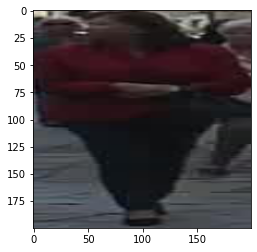

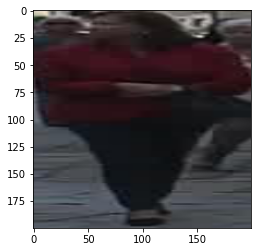

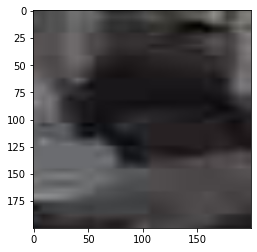

In [28]:
# visualize the triplet
idx = 10
plt.imshow(anchor_images[idx,:,:,:])
plt.show()
plt.imshow(positive_images[idx,:,:,:])
plt.show()
plt.imshow(negative_images[idx,:,:,:])
plt.show()

In [29]:
# TODO: Change the following, I use this limit so that it processes
num_im_dataset = 10
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

In [30]:
negative_dataset

<TensorSliceDataset shapes: (200, 200, 3), types: tf.float32>

In [39]:
dataset

<ZipDataset shapes: ((200, 200, 3), (200, 200, 3), (200, 200, 3)), types: (tf.float32, tf.float32, tf.float32)>

In [40]:
train_dataset

<PrefetchDataset shapes: ((None, 200, 200, 3), (None, 200, 200, 3), (None, 200, 200, 3)), types: (tf.float32, tf.float32, tf.float32)>

In [31]:
image_count = len(anchor_images)
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

In [32]:
train_dataset = train_dataset.batch(4, drop_remainder=False) # 2 instead of 32
train_dataset = train_dataset.prefetch(2) #1 instead of 8

val_dataset = val_dataset.batch(4, drop_remainder=False) # 2 instead of 32
val_dataset = val_dataset.prefetch(2) # 1 instead of 8

In [33]:
train_dataset

<PrefetchDataset shapes: ((None, 200, 200, 3), (None, 200, 200, 3), (None, 200, 200, 3)), types: (tf.float32, tf.float32, tf.float32)>

## Design Siamese Network

In [34]:
# the code in this cell is largely based on the code found here: https://keras.io/examples/vision/siamese_network/

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

In [35]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = False # instead of True
    layer.trainable = trainable


In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [37]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


# visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])


In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
# siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

In [ ]:
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

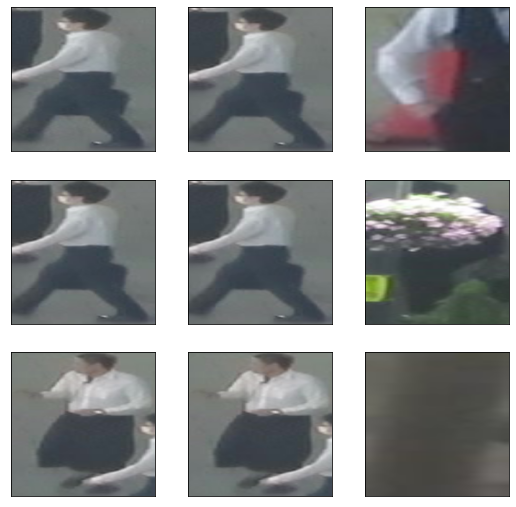

In [42]:
sample = next(iter(val_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)


In [23]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


Positive similarity: 0.9999401
Negative similarity 0.99887955


## Other code

In [ ]:
# based entirely on code done in programming assignement of course4 - week 2 of cs230.

from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

In [ ]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = pos_dist - neg_dist + alpha
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(0.,basic_loss))
    ### END CODE HERE ###
    
    return loss

In [ ]:
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
              tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
              tf.random_normal([3, 128], mean=3, stddev=4, seed = 1))
    loss = triplet_loss(y_true, y_pred)
    
    print("loss = " + str(loss.eval()))

In [ ]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel) # I can load these weights, but I would need to tune on them afterwards because
                                   # I dont only recognize faces, but whole bodies